In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_test = pd.read_csv("./merged_data.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model")
model = BertForSequenceClassification.from_pretrained("saved_model")

In [3]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_probabilities = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)

    all_probabilities.append(probabilities) #Değiştir

In [4]:
all_probabilities_l = []

for item in all_probabilities:
    all_probabilities_l.append(item.tolist())

In [5]:
#youden and f1
all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):
    
    best_thres = -1.0
    #best_youden = -1.0
    best_f1 = -1.0
    test_thresholds = np.arange(0.0, 1.0, 0.01).tolist()

    for i_thres in test_thresholds:
        col_prob = all_probabilities_pd.iloc[:,i]
        col_prob= torch.tensor(col_prob)

        col_true = test_labels_pd.iloc[:,i]
        col_true= torch.tensor(col_true)

        col_pred = (col_prob > i_thres).long()

        cm = confusion_matrix(col_true, col_pred)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]

        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        youden_idx = sensitivity + specificity - 1
        f1 = f1_score(col_true, col_pred)

        #if( youden_idx > best_youden ):
        if( youden_idx > best_f1 ):
            #best_youden = youden_idx
            best_f1 = f1
            best_thres = i_thres
    
    found_thres.append(round(best_thres, 2))

print(found_thres)

all_probabilities_pd

[0.96, 0.78, 0.95, 0.96, 0.96, 0.95, 0.92, 0.94, 0.94, 0.96, 0.96]


,0,1,2,3,4,5,6,7,8,9,10
0,0.011087,0.099466,0.015807,0.020958,0.037879,0.023394,0.031518,0.231742,0.026217,0.867875,0.129285
1,0.025718,0.090988,0.032560,0.059066,0.034768,0.026731,0.021504,0.094663,0.029529,0.940874,0.077178
2,0.020365,0.090594,0.022328,0.027014,0.051276,0.047009,0.024785,0.049635,0.019639,0.933360,0.094261
3,0.008012,0.046389,0.009507,0.010609,0.030370,0.082373,0.018248,0.047058,0.009104,0.490585,0.652667
4,0.024478,0.072047,0.031503,0.033945,0.020812,0.024301,0.014794,0.234009,0.045887,0.886030,0.040890
...,...,...,...,...,...,...,...,...,...,...,...
14769,0.027662,0.348483,0.023504,0.094289,0.677823,0.127232,0.785081,0.024729,0.041943,0.031760,0.356602
14770,0.154110,0.515841,0.140248,0.039016,0.329912,0.021446,0.174572,0.034689,0.046120,0.268924,0.062502
14771,0.948024,0.099745,0.886913,0.045715,0.075573,0.023920,0.068541,0.081578,0.210942,0.037379,0.047589
14772,0.160389,0.251957,0.156761,0.146325,0.115675,0.028677,0.038023,0.043693,0.066369,0.928067,0.031034


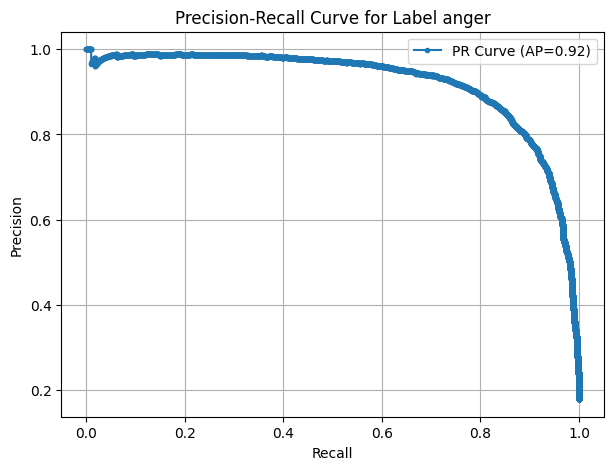

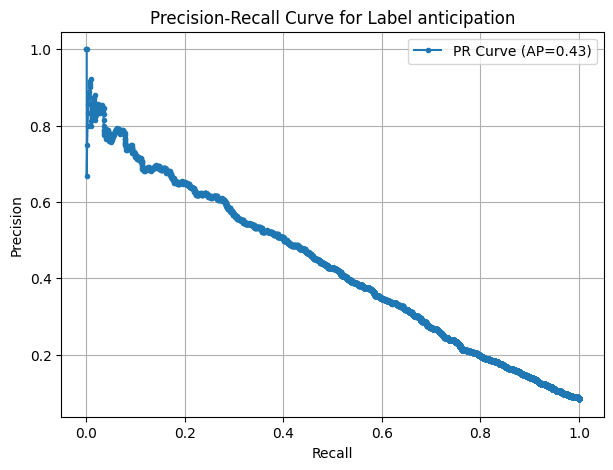

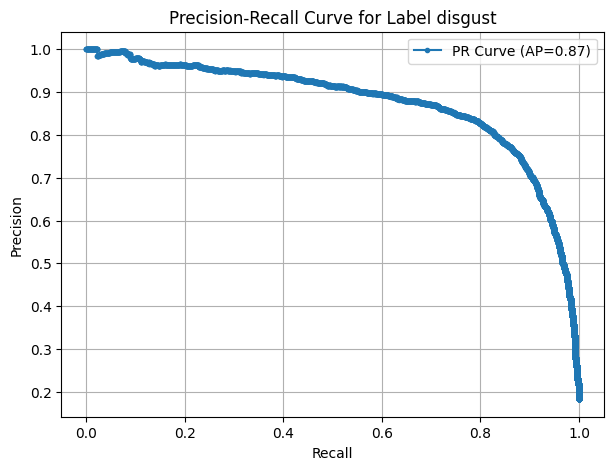

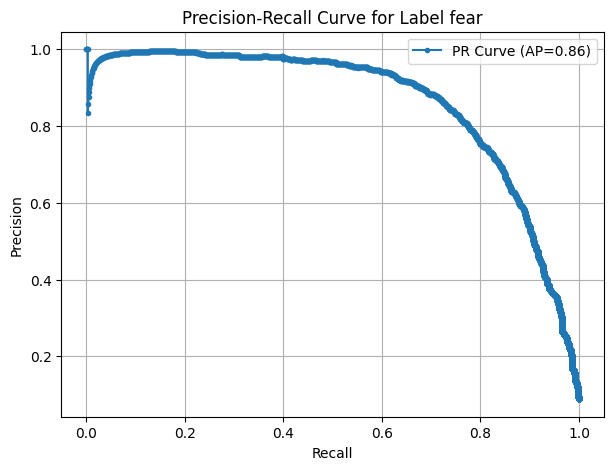

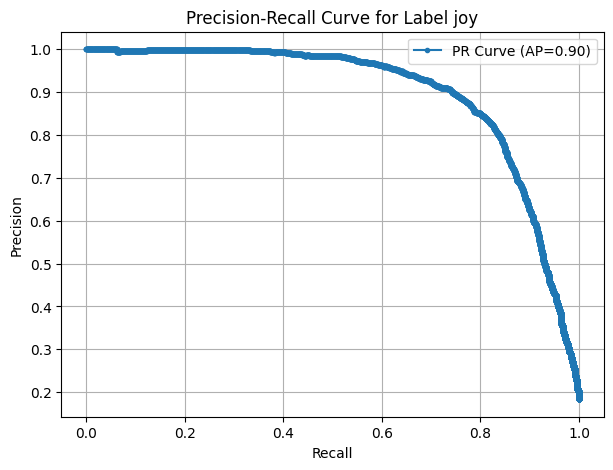

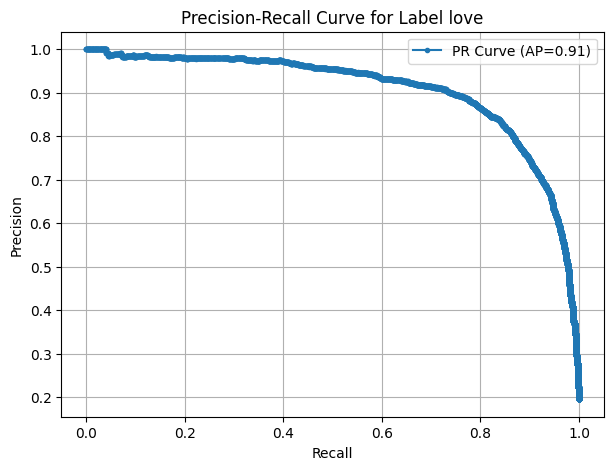

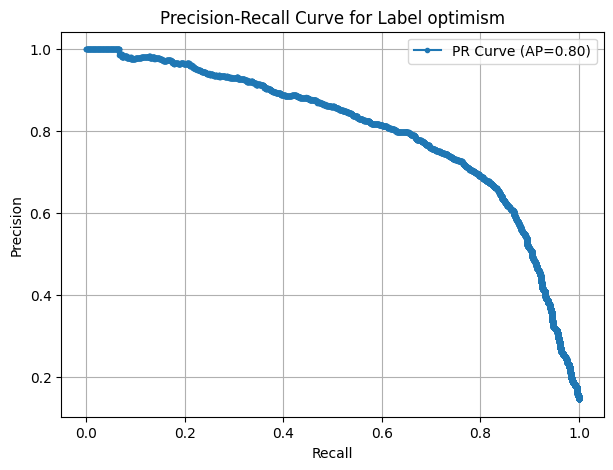

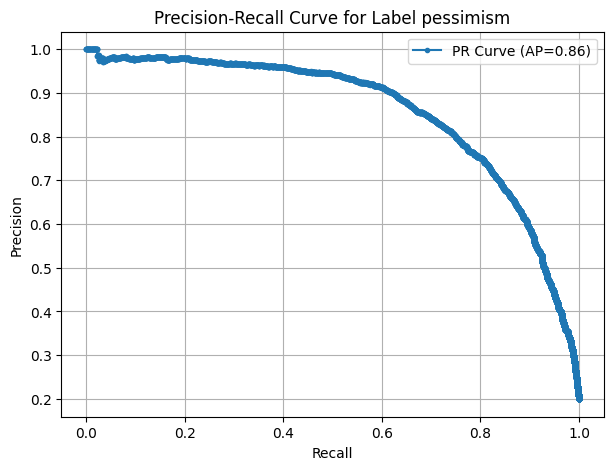

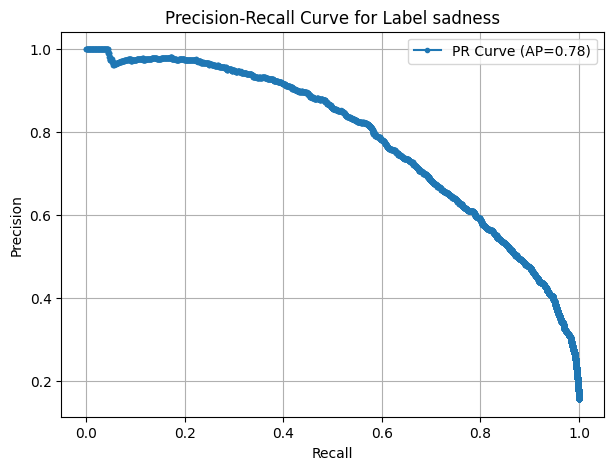

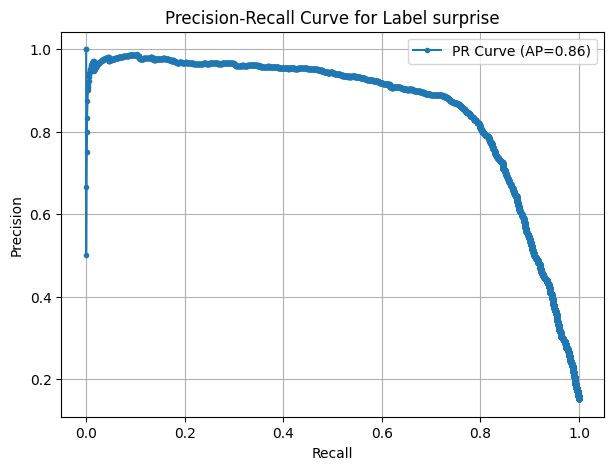

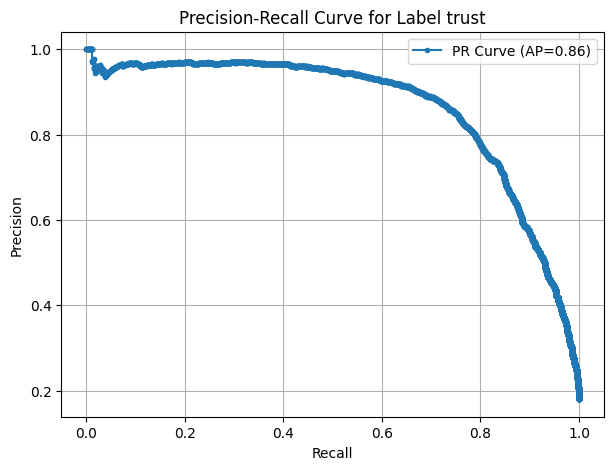

[0.38, 0.3, 0.39, 0.47, 0.41, 0.45, 0.49, 0.34, 0.39, 0.49, 0.48]


,0,1,2,3,4,5,6,7,8,9,10
0,0.011087,0.099466,0.015807,0.020958,0.037879,0.023394,0.031518,0.231742,0.026217,0.867875,0.129285
1,0.025718,0.090988,0.032560,0.059066,0.034768,0.026731,0.021504,0.094663,0.029529,0.940874,0.077178
2,0.020365,0.090594,0.022328,0.027014,0.051276,0.047009,0.024785,0.049635,0.019639,0.933360,0.094261
3,0.008012,0.046389,0.009507,0.010609,0.030370,0.082373,0.018248,0.047058,0.009104,0.490585,0.652667
4,0.024478,0.072047,0.031503,0.033945,0.020812,0.024301,0.014794,0.234009,0.045887,0.886030,0.040890
...,...,...,...,...,...,...,...,...,...,...,...
14769,0.027662,0.348483,0.023504,0.094289,0.677823,0.127232,0.785081,0.024729,0.041943,0.031760,0.356602
14770,0.154110,0.515841,0.140248,0.039016,0.329912,0.021446,0.174572,0.034689,0.046120,0.268924,0.062502
14771,0.948024,0.099745,0.886913,0.045715,0.075573,0.023920,0.068541,0.081578,0.210942,0.037379,0.047589
14772,0.160389,0.251957,0.156761,0.146325,0.115675,0.028677,0.038023,0.043693,0.066369,0.928067,0.031034


In [6]:
#Precision-Recall curve 

from sklearn.metrics import precision_recall_curve, average_precision_score

def optimize_threshold_pr(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):

    col_prob = all_probabilities_pd.iloc[:,i]
    col_prob= torch.tensor(col_prob)

    col_true = test_labels_pd.iloc[:,i]
    col_true= torch.tensor(col_true)

    best_thresh = optimize_threshold_pr(col_true, col_prob)

    precisions, recalls, thresholds = precision_recall_curve(col_true, col_prob)
    ap_score = average_precision_score(col_true, col_prob)

    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, marker=".", label=f"PR Curve (AP={ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Label {emotions[i]}")
    plt.legend()
    plt.grid()
    plt.show()
    
    found_thres.append(round(best_thresh, 2))

print(found_thres)

all_probabilities_pd